In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile

# Step 2: Path to the ZIP file in Drive
zip_path = '/content/cropped.zip'  # Change if your ZIP is in a different folder
extract_to = '/content/cropped_extracted'  # Destination folder in Colab

# Step 3: Extract ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("✅ ZIP file extracted to:", extract_to)


Found 8905 images belonging to 6 classes.
Found 1068 images belonging to 6 classes.
Found 765 images belonging to 6 classes.
🔁 Resuming from checkpoint...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9918 - loss: 0.0304
Epoch 1: saving model to cnn_model_checkpoint.keras
279/279 ━━━━━━━━━━━━━━━━━━━━ 42s 142ms/step - accuracy: 0.9918 - loss: 0.0304 - val_accuracy: 0.8773 - val_loss: 0.5772
Epoch 2/5
279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9913 - loss: 0.0320
Epoch 2: saving model to cnn_model_checkpoint.keras
279/279 ━━━━━━━━━━━━━━━━━━━━ 37s 131ms/step - accuracy: 0.9913 - loss: 0.0320 - val_accuracy: 0.8951 - val_loss: 0.5226
Epoch 3/5
279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9955 - loss: 0.0184
Epoch 3: saving model to cnn_model_checkpoint.keras
279/279 ━━━━━━━━━━━━━━━━━━━━ 43s 138ms/step - accuracy: 0.9955 - loss: 0.0184 - val_accuracy: 0.9110 - val_loss: 0.5218
Epoch 4/5
279/279 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9954 - loss: 0.0170
Epoch 4: saving model to cnn_model_checkpoint.keras
279/279 ━━━━━━━━━━━━━━━━━━━━ 39s 139ms/step - accuracy: 0.9954 - loss: 0.0171 - val_

<Figure size 1000x800 with 0 Axes>

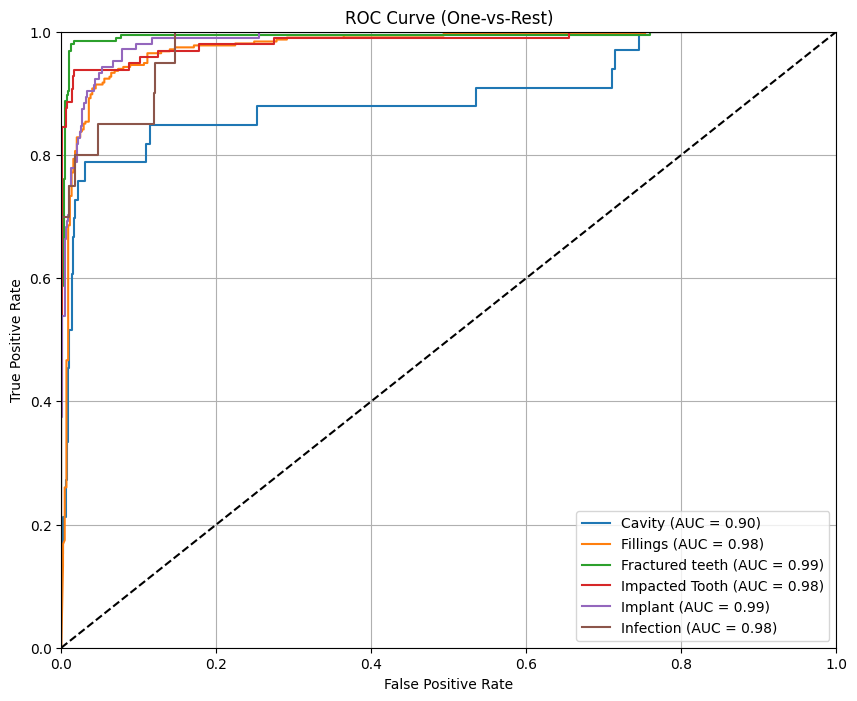

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns


# === Paths ===
train_dir = '/content/drive/MyDrive/my_folder/train'
val_dir = '/content/drive/MyDrive/my_folder/valid'
test_dir = '/content/drive/MyDrive/my_folder/test'
checkpoint_path = 'cnn_model_checkpoint.keras'

# === Parameters ===
img_size = (224, 224)
batch_size = 32
num_classes = 6
epochs = 5

# === Image Preprocessing ===
train_datagen = ImageDataGenerator(rescale=1./255)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_data = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_data = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# === Build CNN Model ===
def build_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# === Load Last Checkpoint or Start New ===
if os.path.exists(checkpoint_path):
    print("🔁 Resuming from checkpoint...")
    model = tf.keras.models.load_model(checkpoint_path)
else:
    print("🚀 Starting new training...")
    model = build_model()

# === Callbacks ===
checkpoint_cb = callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_best_only=False,  # Save after every epoch
    monitor='val_accuracy',
    mode='max',
    save_weights_only=False,
    verbose=1
)

# === Train ===
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=epochs,
    callbacks=[checkpoint_cb]
)

# === Evaluate ===
test_loss, test_acc = model.evaluate(test_data)
print(f"\n✅ Final Test Accuracy: {test_acc * 100:.2f}%")

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Val Accuracy')
    plt.ylim(0, 1)
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.ylim(0, 1)
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()
plt.figure(figsize=(10, 8))
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# === Predictions and Binarizing Labels ===
Y_pred = model.predict(test_data, batch_size=batch_size)  # Get predictions
y_true = test_data.classes  # True labels
y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))  # Binarize true labels

# === Initialize ROC Curve Data ===
fpr, tpr, roc_auc = {}, {}, {}

# Compute ROC curve and AUC for each class
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], Y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# === Plot ROC Curves ===
plt.figure(figsize=(10, 8))

# Ensure that the 'class_names' list is available
class_names = list(test_data.class_indices.keys())

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

# Plot diagonal (random guess) line
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal

# Plot labels and title
plt.xlim(0, 1)
plt.ylim(0, 1)  # Ensure the y-axis range is between 0 and 1
plt.title('ROC Curve (One-vs-Rest)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step

Classification Report:
                 precision    recall  f1-score   support

         Cavity       0.53      0.76      0.62        33
       Fillings       0.91      0.92      0.92       315
Fractured teeth       0.96      0.97      0.97       196
 Impacted Tooth       0.98      0.85      0.91        97
        Implant       0.84      0.84      0.84       104
      Infection       1.00      0.70      0.82        20

       accuracy                           0.90       765
      macro avg       0.87      0.84      0.85       765
   weighted avg       0.91      0.90      0.90       765



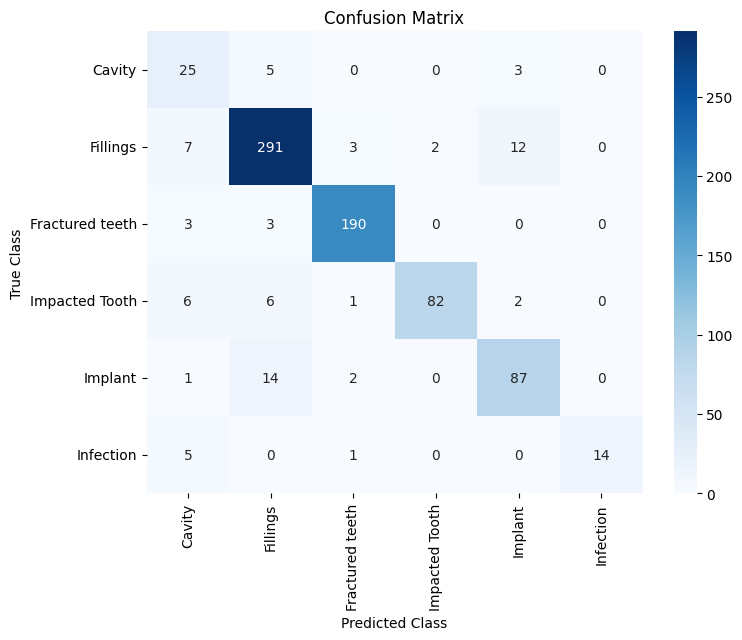

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# === Get Predictions ===
Y_pred = model.predict(test_data, batch_size=batch_size)  # Get model predictions
y_pred = np.argmax(Y_pred, axis=1)  # Get the predicted class indices
y_true = test_data.classes  # True labels

# === Classification Report ===
class_names = list(test_data.class_indices.keys())  # Get class names
report = classification_report(y_true, y_pred, target_names=class_names)
print("\nClassification Report:")
print(report)

# === Confusion Matrix ===
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()
